<a href="https://colab.research.google.com/github/jahnvik16/LangChain-FAQ-Chatbot/blob/main/LangChain_FAQ_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages in Colab
!pip install --quiet sentence-transformers transformers chromadb pdfplumber tqdm streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 42.0 MB/s eta 0:0

In [4]:
import os
import time
import json
import csv
import re
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pdfplumber
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings

from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

sns.set(style="whitegrid")
DATA_DIR = "/mnt/data"
PDF_PATH = os.path.join(DATA_DIR, "/content/openAI PDF.pdf")  # your uploaded file
CHUNK_SIZE = 500   # characters per chunk (tuneable)
CHUNK_OVERLAP = 100


In [5]:
# Extract text from PDF using pdfplumber
def extract_text_from_pdf(pdf_path):
    pages = []
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            text = page.extract_text()
            if text:
                pages.append(text)
    return "\n".join(pages)

raw_text = extract_text_from_pdf(PDF_PATH)
print(f"Extracted {len(raw_text)} characters from PDF.")
print(raw_text[:800])  # preview first 800 characters


Extracted 19592 characters from PDF.
AI in the
Enterprise
Lessons from seven frontier companies
Contents
A new way to work 3
Executive summary 5
Seven lessons for enterprise AI adoption
Start with evals 6
Embed AI into your products 9
Start now and invest early 11
Customize and fine-tune your models 13
Get AI in the hands of experts 16
Unblock your developers 18
Set bold automation goals 21
Conclusion 22
More resources 24
2 AI in the Enterprise
A new way
to work
As an AI research and deployment company, OpenAI prioritizes partnering with global companies
because our models will increasingly do their best work with sophisticated, complex,
interconnected workflows and systems.
We’re seeing AI deliver significant, measurable improvements on three fronts:
01 Workforce performance Helping people deliver higher-quality outputs in s


In [6]:
# Basic cleaning: remove repeated headers/footers and multiple newlines, trim spaces
def clean_document_text(text):
    # Remove common header/footer phrases that repeat (adjust as necessary)
    text = re.sub(r"AI in the Enterprise", " ", text, flags=re.IGNORECASE)
    # Remove URLs
    text = re.sub(r"http[s]?://\S+", " ", text)
    # Convert multiple whitespace/newlines to single newline
    text = re.sub(r"\n\s*\n+", "\n\n", text)
    # Replace many spaces with one
    text = re.sub(r"[ \t]+", " ", text)
    return text.strip()

clean_text = clean_document_text(raw_text)
print(f"Cleaned text length: {len(clean_text)} chars")
print(clean_text[:800])


Cleaned text length: 19130 chars
AI in the
Enterprise
Lessons from seven frontier companies
Contents
A new way to work 3
Executive summary 5
Seven lessons for enterprise AI adoption
Start with evals 6
Embed AI into your products 9
Start now and invest early 11
Customize and fine-tune your models 13
Get AI in the hands of experts 16
Unblock your developers 18
Set bold automation goals 21
Conclusion 22
More resources 24
2 
A new way
to work
As an AI research and deployment company, OpenAI prioritizes partnering with global companies
because our models will increasingly do their best work with sophisticated, complex,
interconnected workflows and systems.
We’re seeing AI deliver significant, measurable improvements on three fronts:
01 Workforce performance Helping people deliver higher-quality outputs in shorter
time frames.



In [7]:
# A small but realistic general FAQ list (you can expand these)
extra_faqs = [
    {"question": "What is a language model?", "answer": "A language model is a statistical model that predicts the probability of a sequence of words. Modern LMs like transformers are trained on large text corpora to generate or score text."},
    {"question": "What is fine-tuning?", "answer": "Fine-tuning is training a pretrained model on task-specific data to adapt it to new tasks or domains."},
    {"question": "What is embeddings-based retrieval?", "answer": "Converting text into vector representations such that semantically similar texts are close together in vector space; used for semantic search."},
    {"question": "How does RAG work?", "answer": "RAG (Retrieval-Augmented Generation) retrieves relevant documents or passages and conditions a generative model on them to produce accurate, grounded answers."},
    {"question": "What is semantic search?", "answer": "Semantic search uses embeddings and vector similarity to find text that is semantically similar rather than relying on keyword matching."}
]

# Convert to a simple text block format and check
len(extra_faqs), extra_faqs[0]


(5,
 {'question': 'What is a language model?',
  'answer': 'A language model is a statistical model that predicts the probability of a sequence of words. Modern LMs like transformers are trained on large text corpora to generate or score text.'})

In [8]:
# Helper: chunk a long text into overlapping pieces (character-based)
def chunk_text(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    chunks = []
    start = 0
    text_len = len(text)
    while start < text_len:
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk.strip())
        start = end - overlap  # move with overlap
        if start < 0:
            start = 0
    return [c for c in chunks if len(c) > 20]  # filter tiny chunks

# Chunk the cleaned PDF
pdf_chunks = chunk_text(clean_text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP)
print("Number of PDF chunks:", len(pdf_chunks))

# Turn extra_faqs into chunks too (keep Q/A per chunk)
faq_chunks = [f"Q: {f['question']}\nA: {f['answer']}" for f in extra_faqs]
print("Number of FAQ chunks:", len(faq_chunks))

# Combine all chunks; build metadata
all_chunks = []
for i, c in enumerate(pdf_chunks):
    all_chunks.append({"id": f"pdf_{i}", "text": c, "source": "uploaded_pdf"})
for i, c in enumerate(faq_chunks):
    all_chunks.append({"id": f"faq_{i}", "text": c, "source": "extra_faq"})

print("Total chunks:", len(all_chunks))


Number of PDF chunks: 48
Number of FAQ chunks: 5
Total chunks: 53


In [9]:
# Initialize sentence-transformers model
embed_model_name = "all-MiniLM-L6-v2"  # small, fast, good for semantic search
embedder = SentenceTransformer(embed_model_name)

# Create Chroma client & collection (in-memory)
# Create a directory for Chroma persistence
chroma_dir = "./chroma_db"
os.makedirs(chroma_dir, exist_ok=True)
client = chromadb.PersistentClient(path=chroma_dir)

# Get the collection if it exists, otherwise create it
try:
    collection = client.get_collection(name="faq_collection")
    print("Using existing collection:", collection.count())
except:
    collection = client.create_collection(name="faq_collection")
    print("Created new collection.")


# Compute embeddings and add to Chroma
texts = [c["text"] for c in all_chunks]
ids = [c["id"] for c in all_chunks]
metadatas = [{"source": c["source"]} for c in all_chunks]

# Compute embeddings in batches with progress bar
batch_size = 64
all_embeddings = []
for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
    batch_texts = texts[i:i+batch_size]
    emb = embedder.encode(batch_texts, convert_to_numpy=True, show_progress_bar=False)
    all_embeddings.append(emb)
all_embeddings = np.vstack(all_embeddings)

# Add to Chroma collection
collection.add(ids=ids, documents=texts, metadatas=metadatas, embeddings=all_embeddings.tolist())
print("Indexed chunks in Chroma:", collection.count())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Created new collection.


Embedding batches: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

Indexed chunks in Chroma: 53


In [10]:
import torch
# Load a seq2seq model and tokenizer for text generation
model_name = "google/flan-t5-base"  # good balance of quality and speed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create a pipeline for text2text generation (CPU/GPU auto)
generator = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
print("Loaded model:", model_name)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


Loaded model: google/flan-t5-base


In [11]:
import torch  # required for device check

def retrieve_top_k(query, k=4):
    """
    Returns top-k docs from Chroma for the query along with distances (similarity).
    """
    q_emb = embedder.encode([query], convert_to_numpy=True)
    results = collection.query(query_embeddings=q_emb.tolist(), n_results=k, include=['distances','metadatas','documents'])
    docs = []
    for doc, dist, meta, did in zip(results['documents'][0], results['distances'][0], results['metadatas'][0], results['ids'][0]):
        docs.append({"id": did, "text": doc, "distance": dist, "source": meta.get("source")})
    return docs

def build_prompt(question, retrieved_docs):
    """
    Constructs a prompt for the generator model by concatenating retrieved docs.
    Adds an instruction to answer concisely and cite sources where possible.
    """
    context = "\n\n---\n\n".join([f"Source ({d['id']}):\n{d['text']}" for d in retrieved_docs])
    prompt = f"You are a helpful assistant. Use the context below to answer the question. If the context does not contain the answer, say 'I don't know'. Be brief and cite source ids.\n\nContext:\n{context}\n\nQuestion: {question}\n\nAnswer:"
    return prompt

In [12]:
# Path for metrics log
METRICS_CSV = os.path.join(DATA_DIR, "rag_metrics_log.csv")

def ask_question(question, k=4, log=True):
    """
    Full RAG pipeline: retrieve -> generate -> return answer.
    Logs metrics: latency, distances, combined context length.
    """
    t0 = time.time()
    # Retrieve
    docs = retrieve_top_k(question, k=k)
    distances = [d["distance"] for d in docs]
    # Build prompt
    prompt = build_prompt(question, docs)
    t1 = time.time()
    retrieval_time = t1 - t0

    # Generate answer
    gen_t0 = time.time()
    # use generator pipeline; limit output tokens for speed
    out = generator(prompt, max_length=256, do_sample=False)
    gen_t1 = time.time()
    gen_time = gen_t1 - gen_t0

    answer = out[0]['generated_text'].strip()

    # Optionally log metrics
    if log:
        # Ensure the directory exists before writing the file
        os.makedirs(DATA_DIR, exist_ok=True)
        row = {
            "timestamp": datetime.utcnow().isoformat(),
            "question": question,
            "answer": answer[:500].replace("\n"," "),  # truncated for CSV
            "retrieval_time_s": retrieval_time,
            "generation_time_s": gen_time,
            "total_time_s": retrieval_time + gen_time,
            "mean_distance": float(np.mean(distances)) if distances else None,
            "min_distance": float(np.min(distances)) if distances else None,
            "max_distance": float(np.max(distances)) if distances else None,
            "num_docs": len(docs)
        }
        file_exists = os.path.exists(METRICS_CSV)
        with open(METRICS_CSV, "a", newline='', encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=list(row.keys()))
            if not file_exists:
                writer.writeheader()
            writer.writerow(row)

    return {"answer": answer, "docs": docs, "metrics": {"retrieval_time": retrieval_time, "generation_time": gen_time}}

In [13]:
examples = [
    "What are the seven lessons for enterprise AI adoption?",
    "How did Morgan Stanley use evals in their AI deployment?",
    "What is retrieval-augmented generation (RAG)?",
    "How can fine-tuning help e-commerce search, according to the document?"
]

for q in examples:
    print("QUESTION:", q)
    res = ask_question(q, k=4, log=True)
    print("ANSWER:", res["answer"][:800])
    print("SOURCES:", [d['id'] for d in res['docs']])
    print("-"*80)


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


QUESTION: What are the seven lessons for enterprise AI adoption?


Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
/tmp/ipython-input-2837390304.py:32: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),
Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


ANSWER: Start with evals Use a systematic evaluation process to measure how models perform against your use cases. 02 Embed AI in Create new customer experiences and more your products relevant interactions. 03 Start now and The sooner you get going, the more the value compounds. invest early 04 Customize and Tuning AI to the specifics of your use cases can dramatically tune your models increase value. 05 Get AI in the hands The pe --- Source (pdf_5): AI in the Enterprise Lessons from seven frontier companies Contents A new way to work 3 Executive summary 5 Seven lessons for enterprise AI adoption Start with evals 6 Embed AI into your products 9 Start now and invest early 11 Customize and fine-tune your models 13 Get AI in the hands of experts 16 Unblock your developers 18 Set bold automation goal
SOURCES: ['pdf_5', 'pdf_0', 'pdf_4', 'pdf_6']
--------------------------------------------------------------------------------
QUESTION: How did Morgan Stanley use evals in their AI deploymen

Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


ANSWER: Focused on making their financial advisors more efficient and effective. The premise was simple: If advisors could access information faster and reduce the time spent on repe --- Source (pdf_11): search time; and advisors spend more time on client relationships, thanks to task automation and faster insights. The feedback from advisors has been overwhelmingly positive. They’re more engaged with clients, and follow-ups that used to take days now happen within hours.
SOURCES: ['pdf_8', 'pdf_11', 'pdf_7', 'pdf_12']
--------------------------------------------------------------------------------
QUESTION: What is retrieval-augmented generation (RAG)?


Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


ANSWER: retrievals relevant documents or passages and conditions a generative model on them to produce accurate, grounded answers. ---
SOURCES: ['faq_3', 'faq_2', 'pdf_10', 'pdf_44']
--------------------------------------------------------------------------------
QUESTION: How can fine-tuning help e-commerce search, according to the document?
ANSWER: By fine-tuning OpenAI models, the Lowe’s team was able to improve product tagging ac
SOURCES: ['pdf_23', 'pdf_22', 'pdf_25', 'faq_1']
--------------------------------------------------------------------------------


,timestamp,question,answer,retrieval_time_s,generation_time_s,total_time_s,mean_distance,min_distance,max_distance,num_docs
0,2025-10-17 22:34:11.659608,What are the seven lessons for enterprise AI a...,Start with evals Use a systematic evaluation p...,0.066209,6.392450,6.458659,0.634056,0.521587,0.836926,4
1,2025-10-17 22:34:13.999364,How did Morgan Stanley use evals in their AI d...,Focused on making their financial advisors mor...,0.010273,2.328671,2.338944,0.726513,0.550743,0.919989,4
2,2025-10-17 22:34:14.957174,What is retrieval-augmented generation (RAG)?,retrievals relevant documents or passages and ...,0.008280,0.948999,0.957279,1.221275,0.605962,1.491788,4
3,2025-10-17 22:34:16.663003,"How can fine-tuning help e-commerce search, ac...","By fine-tuning OpenAI models, the Lowe’s team ...",0.012607,1.691901,1.704508,0.963476,0.807541,1.073652,4


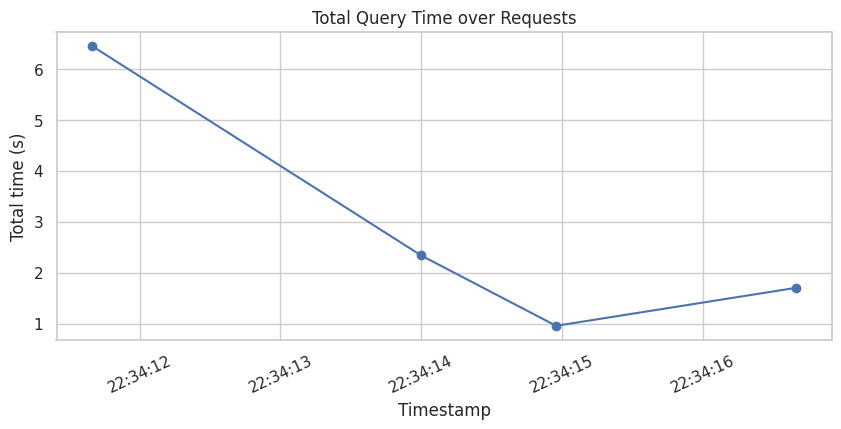

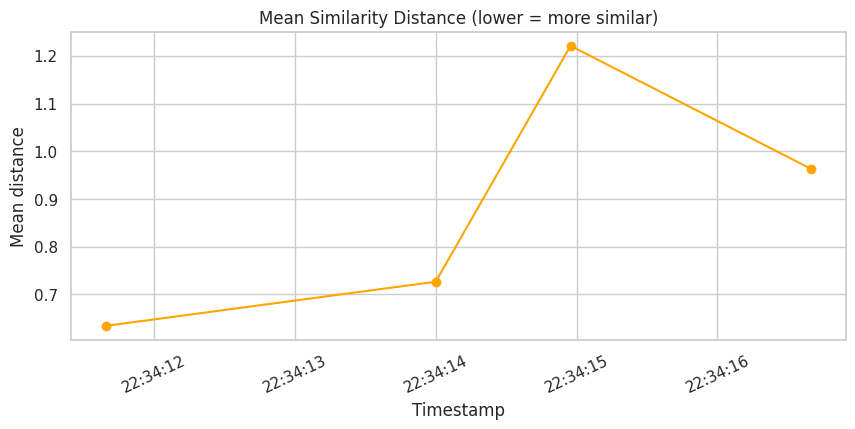

In [14]:
# Read metrics and plot simple dashboard
if os.path.exists(METRICS_CSV):
    df_metrics = pd.read_csv(METRICS_CSV, parse_dates=["timestamp"])
    display(df_metrics.head())

    # Trends: total time over queries
    plt.figure(figsize=(10,4))
    plt.plot(df_metrics['timestamp'], df_metrics['total_time_s'], marker='o')
    plt.title("Total Query Time over Requests")
    plt.xlabel("Timestamp")
    plt.ylabel("Total time (s)")
    plt.xticks(rotation=25)
    plt.grid(True)
    plt.show()

    # Similarity (mean distance) trend
    plt.figure(figsize=(10,4))
    plt.plot(df_metrics['timestamp'], df_metrics['mean_distance'], marker='o', color='orange')
    plt.title("Mean Similarity Distance (lower = more similar)")
    plt.xlabel("Timestamp")
    plt.ylabel("Mean distance")
    plt.xticks(rotation=25)
    plt.grid(True)
    plt.show()
else:
    print("No metrics logged yet. Ask some questions first.")


In [15]:
# If you want to persist Chroma to disk for reuse you can create a persistent collection.
# This requires creating the client with a persist_directory. Example commented out:

persistent_dir = "/content/chroma_persistent"
# client_p = chromadb.Client(Settings(chroma_db_impl="duckdb+parquet", persist_directory=persistent_dir))
client_p = chromadb.PersistentClient(path=persistent_dir)

# Get the collection if it exists, otherwise create it
try:
    collection_p = client_p.get_collection(name="faq_collection_persist")
    print("Using existing persistent collection:", collection_p.count())
except:
    collection_p = client_p.create_collection(name="faq_collection_persist")
    print("Created new persistent collection.")

collection_p.add(ids=ids, documents=texts, metadatas=metadatas, embeddings=all_embeddings.tolist())
print("Persisted collection to", persistent_dir)

print("Chroma in-memory collection active (not persisted).")

Created new persistent collection.
Persisted collection to /content/chroma_persistent
Chroma in-memory collection active (not persisted).


In [16]:
%%bash
cat > /content/langchain_faq_app.py <<'PY'
import streamlit as st
import pandas as pd
import time
from pathlib import Path
from datetime import datetime
import json

# Basic layout
st.set_page_config(page_title="FAQ RAG Chatbot", layout="wide")
st.title("FAQ Chatbot (PDF + General FAQs)")

# Sidebar metrics and controls
st.sidebar.header("Monitoring")
metrics_path = "/mnt/data/rag_metrics_log.csv"
if Path(metrics_path).exists():
    dfm = pd.read_csv(metrics_path, parse_dates=["timestamp"])
    st.sidebar.write("Total queries:", len(dfm))
    st.sidebar.line_chart(dfm[['total_time_s']].rename(columns={'total_time_s':'Total time (s)'}))
else:
    st.sidebar.info("No metrics logged yet. Ask a question to create metrics.")

# User input
question = st.text_area("Ask a question about the docs or AI/ML:", height=120)
k = st.slider("Number of context chunks to retrieve (k)", 1, 8, 4)

if st.button("Get Answer"):
    st.info("Sending query to RAG pipeline...")
    # Call local endpoint implemented via saved JSON as a quick hack in Colab
    # In production, you'd call an API endpoint. Here we call a helper function saved via pickle or run the pipeline inline.
    # For demo, we'll load a precomputed 'last_answer.json' put there by the notebook when ask_question runs.
    ans_file = Path("/mnt/data/last_rag_answer.json")
    if ans_file.exists():
        data = json.loads(ans_file.read_text())
        st.subheader("Answer")
        st.write(data.get("answer"))
        st.subheader("Sources used")
        st.write(data.get("sources"))
    else:
        st.warning("No answer file found. Run the notebook's `ask_question()` to create a sample response.")
PY


In [17]:
# After you run ask_question(q), create a last_rag_answer.json for the Streamlit app to display.
def write_last_answer_json(question, response):
    out = {
        "question": question,
        "answer": response["answer"],
        "sources": [d["id"] for d in response["docs"]],
        "metrics": response.get("metrics")
    }
    out_path = os.path.join(DATA_DIR, "last_rag_answer.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(out, f, indent=2)
    print("Wrote last answer JSON to", out_path)

# Example: run one question and write the JSON
sample_q = "What are the seven lessons for enterprise AI adoption?"
sample_res = ask_question(sample_q, k=4, log=True)
write_last_answer_json(sample_q, sample_res)


Both `max_new_tokens` (=256) and `max_length`(=256) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Wrote last answer JSON to /mnt/data/last_rag_answer.json


/tmp/ipython-input-2837390304.py:32: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


In [ ]:
# 1) Install pyngrok (already installed above) and set your ngrok authtoken (you need your token string)

from pyngrok import ngrok
ngrok.set_auth_token("342My5Dj1IuX9uUhmWDC4JWsTdQ_4Syn5XurPXLznTp6nAr5n")

# 2) Start Streamlit in background and create tunnel (example commands below):
!streamlit run /content/langchain_faq_app.py --server.port 8501 &

# Then create an ngrok tunnel to port 8501:
public_url = ngrok.connect(8501)
print("Streamlit public URL:", public_url)

# 3) Open the printed public URL in your browser.





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.168.115.227:8501

